## Image GPT 

Generative Pretrained Transformer trained for further usage in downstream tasks such as classificiation.

Paper Links  
 * Image GPT :  
 https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf
 
 * GPT - 2 Paper :  
 https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf  
 
 * GPT Paper :  
 https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf  

 * Image Transformers :  
 https://arxiv.org/pdf/1802.05751.pdf


### The Transformer Architecture  

<img src="https://miro.medium.com/max/1838/1*BHzGVskWGS_3jEcYYi6miQ.png" width=500 />

## The GPT-2 Decoder Only Architecture  
<img src="https://i.stack.imgur.com/Kb8Gq.png" height=500 />

## Attention :  
<img src="https://ryanong.co.uk/wp-content/uploads/2020/01/Attention-formula.png" width=500 />  
<br />

Q = Query Matrix  
K = Key Matrix  
V = Value Matrix  

d_k = Embedding dimension  

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
# Hyperparameters

npx = 28              # Image dimension pixels
maxlen = npx*npx      # Maximum length of the sequence after flattening
embed_dim = 128       # Embedding dimension
num_heads = 4         # Number of heads for the multihead attention layer
num_vocab = 256       # Size of the vocabulary, 256 values (0 to 255)
num_layers = 5        # Number of layers

num_epochs = 20       # Number of epochs
num_batch = 64        # Batch Size

In [ ]:
# Necessary imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras import datasets, models
# import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os

TRAIN = True
RETRAIN = False
SAVE = False
CREATE_NEW = True
LOAD = False

In [ ]:
# One block of the decoder

def causal_attention_mask(batch_size, n_dest, n_src, dtype):
  """This function returns the mask to be used in the attention layer"""

  i = tf.range(n_dest)[:, None]
  j = tf.range(n_src)
  m = i >= j - n_src + n_dest
  mask = tf.cast(m, dtype)
  mask = tf.reshape(mask, [1, n_dest, n_src])
  mult = tf.concat(
      [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
  )
  return tf.tile(mask, mult)

class TransformerBlock(layers.Layer):
  def __init__(self, embed_dim, num_heads):
    super(TransformerBlock, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
        [layers.Dense(embed_dim*4, activation="relu"),
         tfa.layers.GELU(),
         layers.Dense(embed_dim, activation="relu")]
    )
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size = input_shape[0]
    seq_len = input_shape[1]
    causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
    attn_output, weights = self.att(inputs, inputs, attention_mask=causal_mask, return_attention_scores=True)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)

    return self.layernorm2(out1 + ffn_output)

In [ ]:
# Embedding layer

class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

In [ ]:
def create_model():
  inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
  embedding_layer = TokenAndPositionEmbedding(maxlen, num_vocab, embed_dim)
  x = embedding_layer(inputs)

  transformer_block = TransformerBlock(embed_dim, num_heads)

  for i in range(num_layers):
    x = transformer_block(x)
  x = layers.LayerNormalization(epsilon=1e-6)(x)

  outputs = layers.Dense(num_vocab)(x)
  model = keras.Model(inputs=inputs, outputs=[outputs, x])

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  model.compile(
      tf.keras.optimizers.Adam(learning_rate = 1e-3), loss=[loss_fn],
  )   # No loss and optimization based on word embeddings from transformer block
  return model

In [ ]:
if(CREATE_NEW):
  model = create_model()
elif (LOAD):
  os.system("mkdir variables && mv variables.* variables")
  model = keras.models.load_model('./')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 token_and_position_embedding (  (None, 784, 128)    133120      ['input_1[0][0]']                
 TokenAndPositionEmbedding)                                                                       
                                                                                                  
 transformer_block (Transformer  (None, 784, 128)    396032      ['token_and_position_embedding[0]
 Block)                                                          [0]',                            
                                                                  'transformer_block[0][0]',  

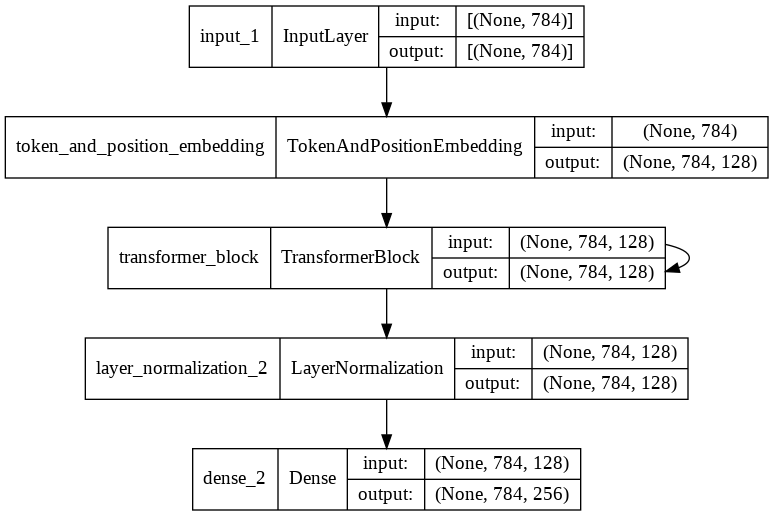

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Data Processing steps
# Note that MNIST dataset need not be quantized since it is already grayscale

num_classes = 10
input_shape = (npx, npx, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

np.random.shuffle(x_train)

x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

y_new_train=y_train[10000:20000]

x_train = x_train[10000:20000, :]

x_train = tf.cast(tf.reshape(x_train, (x_train.shape[0], npx**2)), tf.int32)
x_test = tf.cast(tf.reshape(x_test, (x_test.shape[0], npx**2)), tf.int32)

y_train = tf.cast(x_train, tf.int32)
y_test = tf.cast(x_test, tf.int32)

sos = -1*tf.zeros((x_train.shape[0], 1), dtype=tf.int32)
x_train = tf.concat([sos, x_train[:, :-1]], 1)
x_test = tf.concat([sos, x_test[:, :-1]], 1)

# cropping the test images into half and padding the rest with zeros
x_test = x_test[:, :maxlen//2]

In [ ]:
if(TRAIN or RETRAIN):
  history = model.fit(
      x_train, y_train, batch_size=64, epochs=15
  )

Epoch 1/15
157/157 [==============================] - 359s 2s/step - loss: 0.5603 - dense_2_loss: 0.5603
Epoch 2/15
157/157 [==============================] - 360s 2s/step - loss: 0.5562 - dense_2_loss: 0.5562
Epoch 3/15
157/157 [==============================] - 360s 2s/step - loss: 0.5552 - dense_2_loss: 0.5552
Epoch 4/15
157/157 [==============================] - 359s 2s/step - loss: 0.5540 - dense_2_loss: 0.5540
Epoch 5/15
157/157 [==============================] - 359s 2s/step - loss: 0.5534 - dense_2_loss: 0.5534
Epoch 6/15
157/157 [==============================] - 360s 2s/step - loss: 0.5519 - dense_2_loss: 0.5519
Epoch 7/15
157/157 [==============================] - 360s 2s/step - loss: 0.5511 - dense_2_loss: 0.5511
Epoch 8/15
157/157 [==============================] - 360s 2s/step - loss: 0.5503 - dense_2_loss: 0.5503
Epoch 9/15
157/157 [==============================] - 360s 2s/step - loss: 0.5495 - dense_2_loss: 0.5495
Epoch 10/15
157/157 [==============================] - 

In [ ]:
SAVE = True
if(SAVE):
  model.save('./drive/MyDrive/GNR 638 project/model3')


## Utility function

In [ ]:
def getPixel(oneHots):
  """Converts a 1-Hot vector to its pixel value"""
  return tf.math.argmax(oneHots, axis=-1)

## Generation

In [ ]:
num_samples = 8

In [ ]:
x_test.shape

In [ ]:
# Image generation

sample = x_test[:num_samples]

sample.shape

In [ ]:
def predict_rest(context):
  """This reconstructs one image"""
  start_tokens = [_ for _ in context]
  num_tokens_generated = 0
  tokens_generated = []
  while num_tokens_generated < (maxlen-maxlen//2):
    pad_len = maxlen - len(start_tokens)
    sample_index = len(start_tokens) - 1
    if pad_len < 0:
      x = start_tokens[:maxlen]
      sample_index = maxlen - 1
    elif pad_len > 0:
      x = start_tokens + [0] * pad_len
    else:
      x = start_tokens
    x = tf.expand_dims(tf.convert_to_tensor(x, dtype=tf.int64), axis=0)
    y, _ = model.predict(x)
    sample_token = getPixel(y[0][sample_index])
    tokens_generated.append(sample_token)
    start_tokens.append(sample_token)
    num_tokens_generated = len(tokens_generated)
  return start_tokens

random_gen = [predict_rest(img) for img in sample]

In [ ]:
random_gen = [tf.convert_to_tensor(img, dtype=tf.int64).numpy() for img in random_gen]

In [ ]:
tf.convert_to_tensor(random_gen).shape

In [ ]:
reshapes = []

for i in range(len(random_gen)):
  img = random_gen[i]

  img = np.reshape(img, (npx, npx))
  reshapes.append(img)

reshapes = np.asarray(reshapes)

sample = x_test[:num_samples]
sample = [list(img) + [0]*(maxlen//2) for img in sample]
sample = np.reshape(sample, (len(sample), npx, npx))

In [ ]:
fig = plt.figure(figsize=(18, 10))

for i in range(num_samples*2):
  sub = fig.add_subplot(num_samples, 2, i+1)
  if(i%2):
    sub.imshow(reshapes[int(i/2)], cmap='gray')
  else:
    sub.imshow(sample[int(i/2)], cmap='gray')

# Probing

In [ ]:
def create_neural_net():
  model1 = Sequential()
  model1.add(tf.keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(128,)))
  model1.add(tf.keras.layers.Dense(10, activation='softmax'))
  model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model1

In [ ]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('transformer_block').output)
feature=[]
for i in range(10000):
  intermediate_output = intermediate_layer_model.predict(np.expand_dims(x_train[i],axis=0))
  sample=intermediate_output.reshape(784,128).mean(axis=0)
  feature.append(sample)
print(np.shape(feature))
neural_net=create_neural_net()
history=neural_net.fit(np.array(feature),np.array(y_new_train), epochs=150, batch_size=32)

(10000, 128)
Epoch 1/150
313/313 [==============================] - 1s 3ms/step - loss: 2.2689 - accuracy: 0.1569
Epoch 2/150
313/313 [==============================] - 1s 3ms/step - loss: 2.1159 - accuracy: 0.2180
Epoch 3/150
313/313 [==============================] - 1s 3ms/step - loss: 2.0180 - accuracy: 0.2446
Epoch 4/150
313/313 [==============================] - 1s 3ms/step - loss: 1.9764 - accuracy: 0.2612
Epoch 5/150
313/313 [==============================] - 1s 3ms/step - loss: 1.9473 - accuracy: 0.2680
Epoch 6/150
313/313 [==============================] - 1s 3ms/step - loss: 1.9269 - accuracy: 0.2753
Epoch 7/150
313/313 [==============================] - 1s 3ms/step - loss: 1.9069 - accuracy: 0.2842
Epoch 8/150
313/313 [==============================] - 1s 3ms/step - loss: 1.8906 - accuracy: 0.2913
Epoch 9/150
313/313 [==============================] - 1s 3ms/step - loss: 1.8786 - accuracy: 0.2951
Epoch 10/150
313/313 [==============================] - 1s 3ms/step - loss: 1.

In [ ]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('layer_normalization_2').output)
feature=[]
for i in range(10000):
  intermediate_output = intermediate_layer_model.predict(np.expand_dims(x_train[i],axis=0))
  sample=intermediate_output.reshape(784,128).mean(axis=0)
  feature.append(sample)
print(np.shape(feature))
neural_net=create_neural_net()
history=neural_net.fit(np.array(feature),np.array(y_new_train), epochs=150, batch_size=32)

(10000, 128)
Epoch 1/150
313/313 [==============================] - 1s 3ms/step - loss: 2.1505 - accuracy: 0.2426
Epoch 2/150
313/313 [==============================] - 1s 3ms/step - loss: 1.8194 - accuracy: 0.3759
Epoch 3/150
313/313 [==============================] - 1s 3ms/step - loss: 1.6234 - accuracy: 0.4267
Epoch 4/150
313/313 [==============================] - 1s 3ms/step - loss: 1.5061 - accuracy: 0.4676
Epoch 5/150
313/313 [==============================] - 1s 3ms/step - loss: 1.4241 - accuracy: 0.5002
Epoch 6/150
313/313 [==============================] - 1s 3ms/step - loss: 1.3605 - accuracy: 0.5235
Epoch 7/150
313/313 [==============================] - 1s 3ms/step - loss: 1.3050 - accuracy: 0.5533
Epoch 8/150
313/313 [==============================] - 1s 3ms/step - loss: 1.2604 - accuracy: 0.5650
Epoch 9/150
313/313 [==============================] - 1s 3ms/step - loss: 1.2176 - accuracy: 0.5801
Epoch 10/150
313/313 [==============================] - 1s 3ms/step - loss: 1.